## Correlation: &thinsp; DOC and subsidence strength (wap)

In [89]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [90]:
from myFuncs import *

In [91]:
plt.rcParams['figure.figsize'] = [10, 7.5]

### one dataset

In [92]:
variable = 'wap'

data_options= [
    'subsidence'
    ]

org_options = [
    'rome',
    # 'o_number'
    ]

models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

observations = [
    ]

datasets = models + observations

resolutions = [
    # 'original',
    'regridded'
    ]

experiments =[
    'historical',
    # 'rcp85'
    ]


print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(variable, datasets[0], experiments[0], resolutions[0]))
ds = get_dsvariable(variable, datasets[0], experiments[0], resolution=resolutions[0])
ds

variable:wap, dataset:GFDL-CM3, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (plev: 8, time: 10950, lat: 22, lon: 128)
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    wap      (time, plev, lat, lon) float32 ...

In [93]:
data = ds['wap'].sel(plev = 500e2)
data

<xarray.DataArray 'wap' (time: 10950, lat: 22, lon: 128)>
[30835200 values with dtype=float32]
Coordinates:
    plev     float64 5e+04
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    regrid_method:  conservative
    units:          hPa day⁻¹

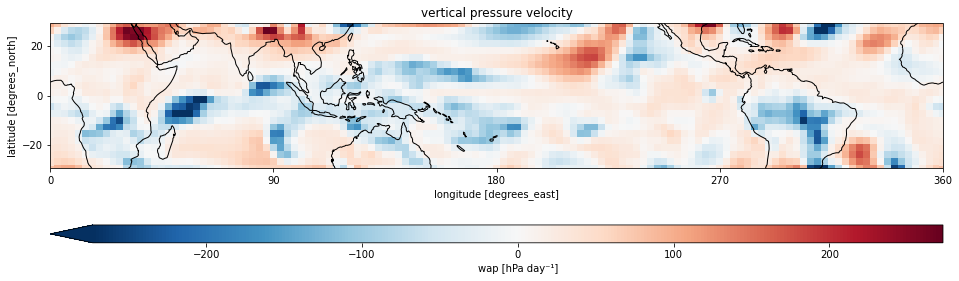

In [94]:
scene = data.isel(time=0)
cmap = 'RdBu_r'
title = 'vertical pressure velocity'
vmin = -np.max(scene)
vmax = np.max(scene)
plot_scene(scene, cmap = cmap, title = title, vmin = vmin, vmax = vmax)

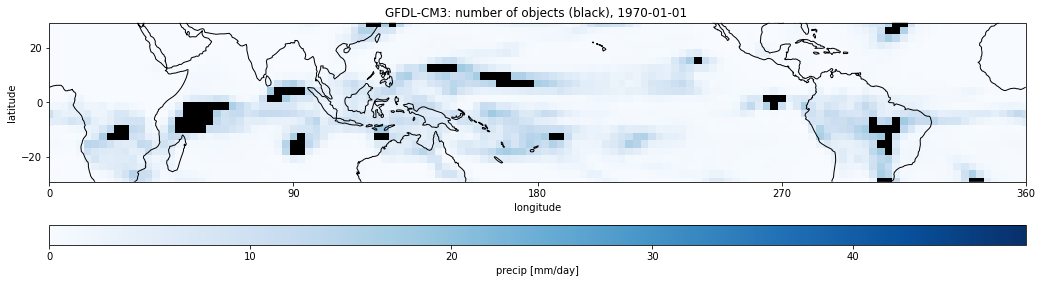

In [97]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black), ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')
plt.show()

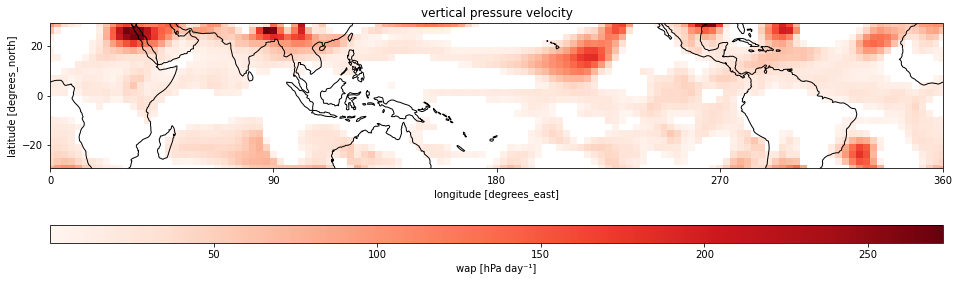

In [95]:
wap_d = True
wap_a = False

if wap_d:
    data = data.where(data>0)
    scene = data.isel(time=0)
    cmap = 'Reds'
    title = 'vertical pressure velocity'
    plot_scene(scene, cmap = cmap, title = title)


if wap_a:
    data = data.where(data<0)
    scene = data.isel(time=0)
    cmap = 'Blues_r'
    title = 'vertical pressure velocity'
    plot_scene(scene, cmap = cmap, title = title)

In [ ]:
# calculate subsidence strength
aWeights = np.cos(np.deg2rad(data.lat))
subs = data.weighted(aWeights).mean(dim=('lat','lon')) 

In [98]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

aWeights = np.cos(np.deg2rad(data.lat))
y = data.weighted(aWeights).mean(dim=('lat','lon')) 
y = resample_timeMean(y, timeMean_options[0])
title = '{} spatial mean of {} from model:{}, experiment:{}'.format(timeMean_options[0], data_options[0], datasets[0], experiments[0])
xlabel = '{} [{} - {}]'.format(timeMean_options[0], str(data.isel(time=0).coords['time'].values)[:10], str(data.isel(time=-1).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(data_options[0], '%')


plot_timeseries(y, title=title, timeMean_option=timeMean_options)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

if timeMean_options[0]=='seasonal':
    plt.legend()

NameError: name 'resample_timeMean' is not defined

### one dataset

In [ ]:
scene = data.isel(time=0)

plot_scene(scene)

hus_d = True
if hus_d:
    wap500 = get_dsvariable('wap', datasets[0], experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
    wap500 = resample_timeMean(wap500, 'monthly')
    wap500 = wap500.assign_coords(time=data.time)
    data = data.where(wap500>0, np.nan)
    scene = data.isel(time=0)

    title = 'example of {} field of descending area at 500 hPa from model:{}, experiment:{}'.format(variable, datasets[0], experiments[0])
    fig= plt.figure(figsize=(17.5,8))
    ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

    lat = scene.lat
    lon = scene.lon
    lonm,latm = np.meshgrid(lon,lat)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

    pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues', vmin=None, vmax=None)
    ax.set_title(title)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'cloudfraction' + ' [{}]'.format('%'))



scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black), ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')
plt.show()

scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=28)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black), ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')
plt.show()

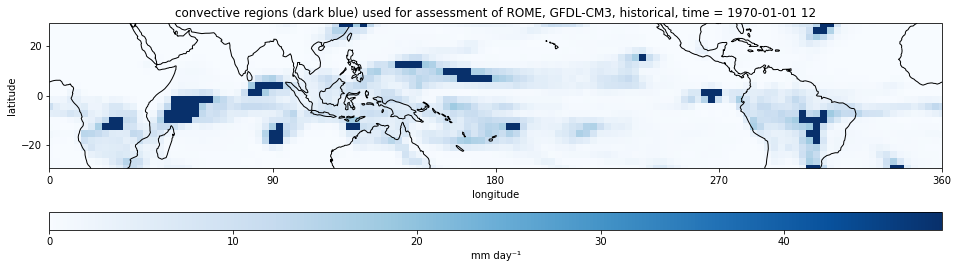

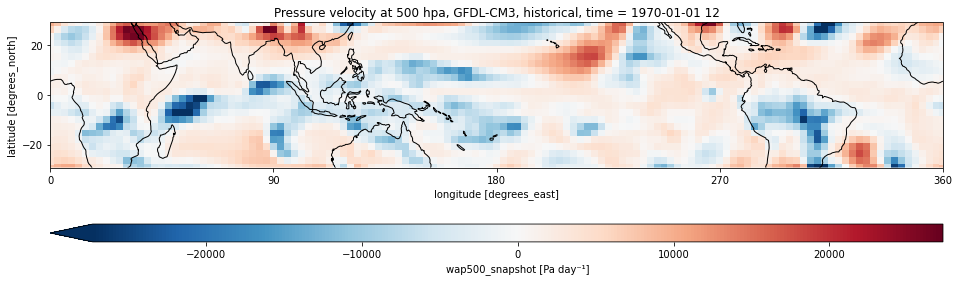

In [3]:
scene_background = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_precip_tMean_historical.nc')['precip_snapshot']
threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_prPercentiles_' + experiment + '.nc').pr97.mean(dim='time').values
L = skm.label(scene_background.where(scene_background>=threshold,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': scene_background.lat.data, 'lon': scene_background.lon.data}
    )
scene1 = labelMatrix.where(labelMatrix>0)
scene2 = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_tMean_historical.nc')['wap500_snapshot']

cmap_background= 'Blues'
cmap = 'Blues_r'
title = 'convective regions (dark blue) used for assessment of ROME, ' + model + ', ' + experiment + ', time = ' + str(scene2.coords['time'].values)[:13] 
plot_sceneThreshold(scene_background, scene1, cmap_background, cmap, title,fig_width=16 ,fig_height=8)

cmap="RdBu_r"
title = 'Pressure velocity at 500 hpa, ' + model + ', historical, ' + 'time = ' + str(scene2.coords['time'].values)[:13] 
vmin = -np.max(scene2)
vmax = np.max(scene2)
plot_scene(scene2, cmap, title, vmin, vmax,fig_width=17.5 ,fig_height=8)


### correlation

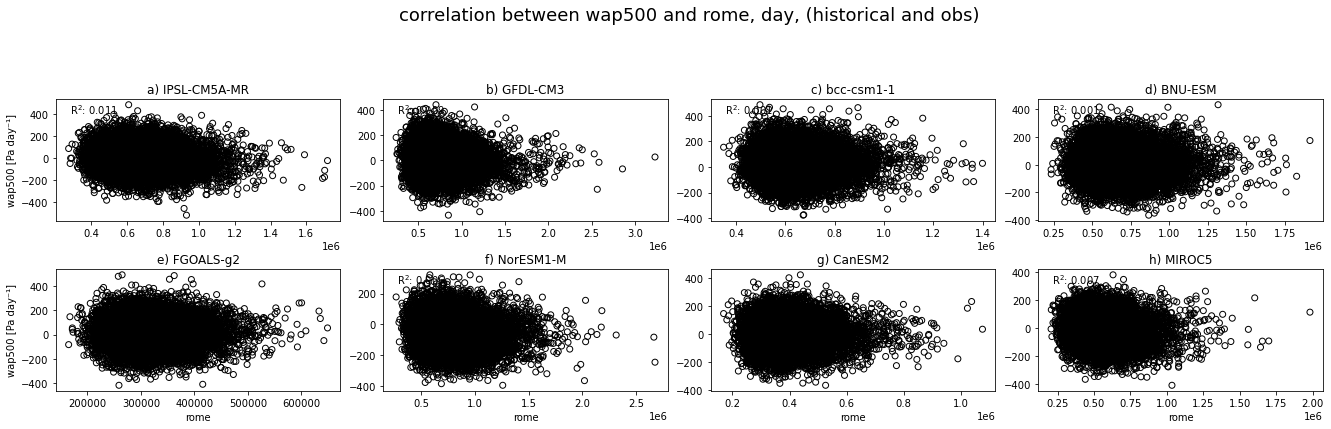

In [5]:
varTypes = [
    # 'wap500',
    'wap500_ascent',
    # 'wap500_ascent'
]
varType = varTypes[0]

timeMean_options = [
    # 'annual',
    # 'season',
    # 'season_mean',
    # 'month',
    # 'month_mean',
    'day',
    ]
timeMean_option = timeMean_options[0]


models = [
    'IPSL-CM5A-MR', # 1 -
    'GFDL-CM3',     # 2 -
    # 'GISS-E2-H',    # 3 # does not have wap
    'bcc-csm1-1',   # 4 -
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # does not have wap
    # 'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8 -
    # 'EC-EARTH',     # 9
    'FGOALS-g2',    # 10 -
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13 # does not have wap
    'NorESM1-M',    # 14 -
    'CanESM2',      # 15 -
    'MIROC5',       # 16 -
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]

observations = [
    # 'GPCP'
]


ds_x = xr.Dataset()
ds_y = xr.Dataset()
for model in models:
    x = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_x[0] +'_' + experiment + '.nc')[variables_x[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ varType +'_' + experiment + '.nc')[varType]
    y_resampled = resample(y, timeMean_option)
    y_resampled.attrs['units']= y.units
    ds_y[model] = y_resampled


for obs in observations:
    x = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables1[0] +'_.nc')[variables1[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables2[0] +'_sMean_.nc')['wap500_sMean']
    y_resampled = resample(y, timeMean_option)
    if varTypes == 'area_ascent':
        y_resampled = ((y_resampled<0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    if varTypes == 'area_descent':
        y_resampled = ((y_resampled>0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    y_resampled.attrs['units']= y.units
    ds_y[obs] = y_resampled


ymin, ymax = [], []
for dataset in list(ds_y.data_vars.keys()):
    ymin = np.append(ymin, ds_y[dataset].min())
    ymax = np.append(ymax, ds_y[dataset].max())

ymin = np.min(ymin)
ymax = np.max(ymax)

xmin, xmax = [], []
for dataset in list(ds_x.data_vars.keys()):
    xmin = np.append(xmin, ds_x[dataset].min())
    xmax = np.append(xmax, ds_x[dataset].max())
xmin = np.min(xmin)
xmax = np.max(xmax)



title = 'correlation between ' + variables_y[0] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'wap500'
xlabel = 'rome'
plot_scatter_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

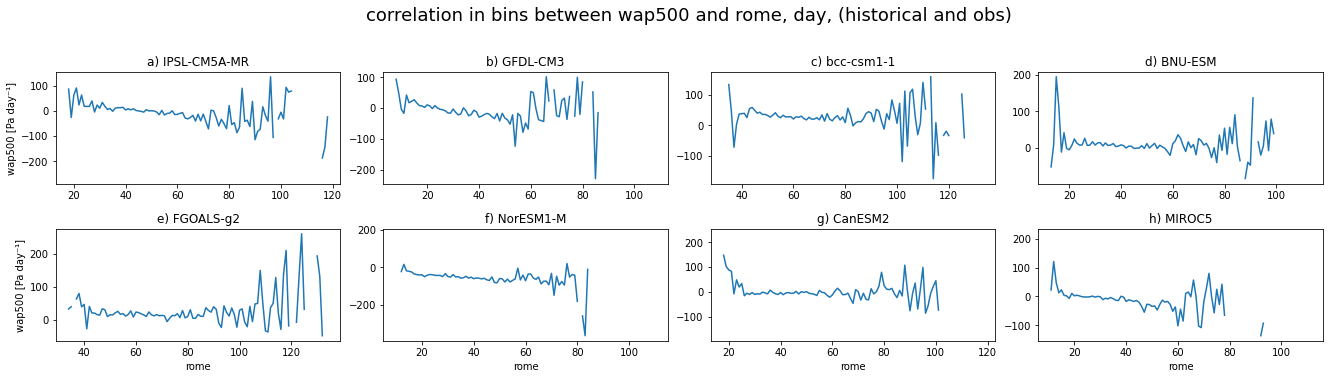

In [6]:
title = 'correlation in bins between ' + variables_y[0] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'wap500'
xlabel = 'rome'
plot_bins_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

In [5]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments=[
    'historical', 
    # 'rcp85'
    ]
experiment = experiments[0]


org_options = [
    'rome',
    # 'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]


area_options = [
    'area_ascent'
    # 'area_descent'
    ]
area_option = area_options[0]


if org_option == 'rome' or org_option == 'rome_n':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]

if org_option == 'o_number':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_numberIndex_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]


folder = home + '/Documents/data/cmip5/ds/'+ model
fileName = model + '_wap500_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
wap500 = ds['wap500']

if area_option == 'area_ascent':
    areaFrac = ((wap500<0)*1).sum(dim=('lat','lon'))/(wap500.shape[1]*wap500.shape[2])*100

if area_option == 'area_descent':
    areaFrac = ((wap500>0)*1).sum(dim=('lat','lon'))/(wap500.shape[1]*wap500.shape[2])*100
areaFrac.attrs['units'] = '%'


aWeights = np.cos(np.deg2rad(wap500.lat))

In [6]:
areaFrac

<xarray.DataArray 'wap500' (time: 10950)>
array([41.15767045, 40.80255682, 40.76704545, ..., 40.05681818,
       37.32244318, 38.24573864])
Coordinates:
    plev     float64 ...
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    units:    %

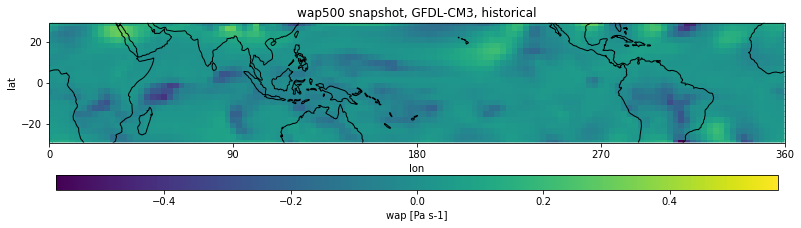

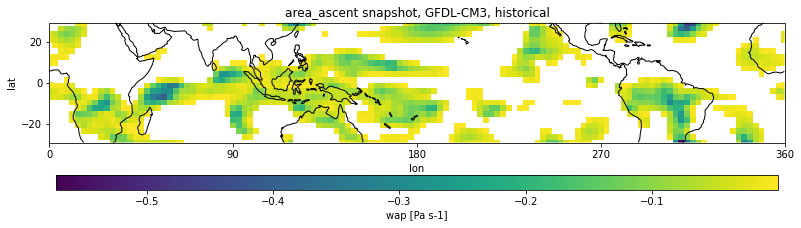

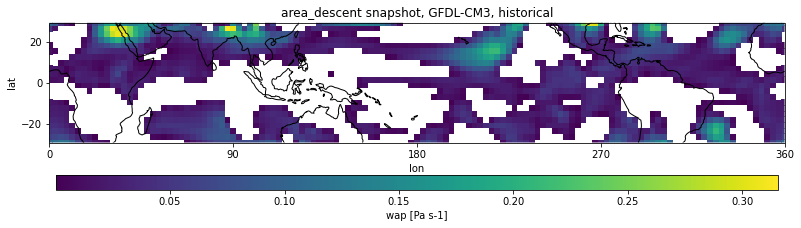

In [7]:
var = wap500.isel(time=0)
variable_name = 'wap500'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

var = wap500.isel(time=0).where(wap500.isel(time=0)<0, np.nan)
variable_name = 'area_ascent'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

var = wap500.isel(time=0).where(wap500.isel(time=0)>0, np.nan)
variable_name = 'area_descent'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

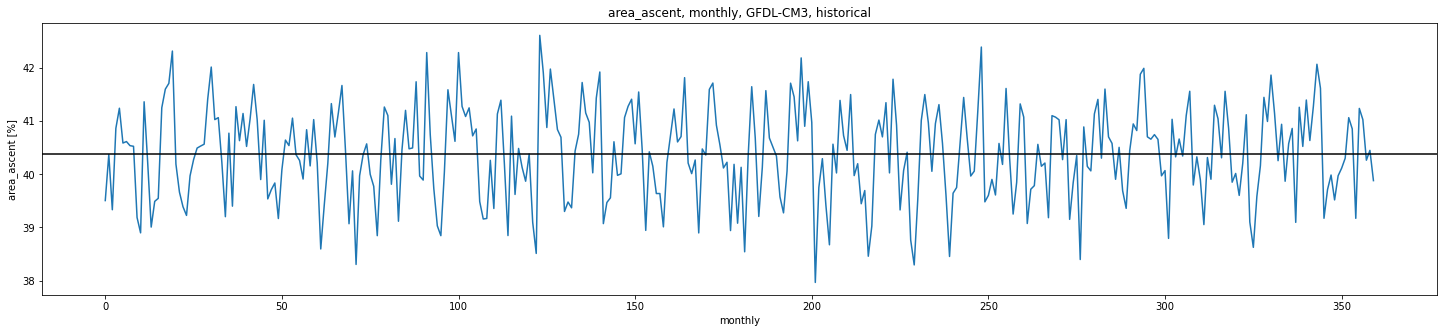

In [8]:
y = areaFrac.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = area_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

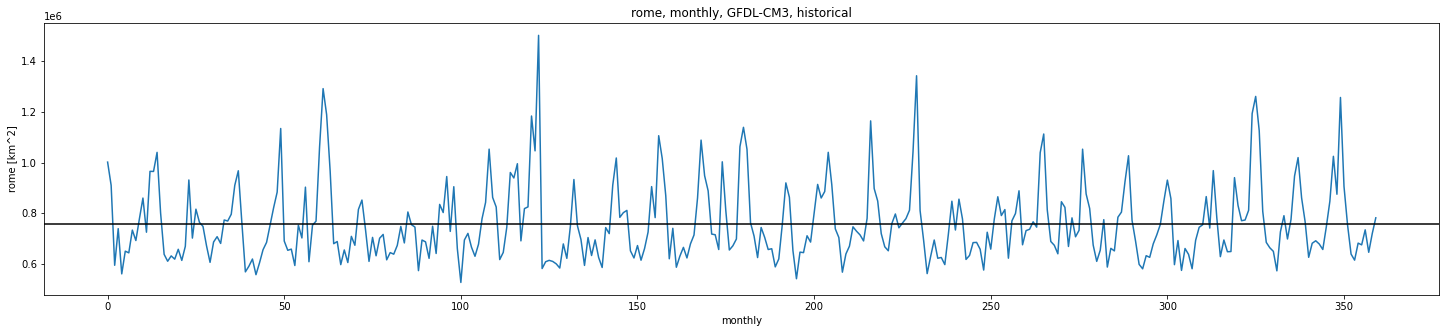

In [9]:
y = org.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = org_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

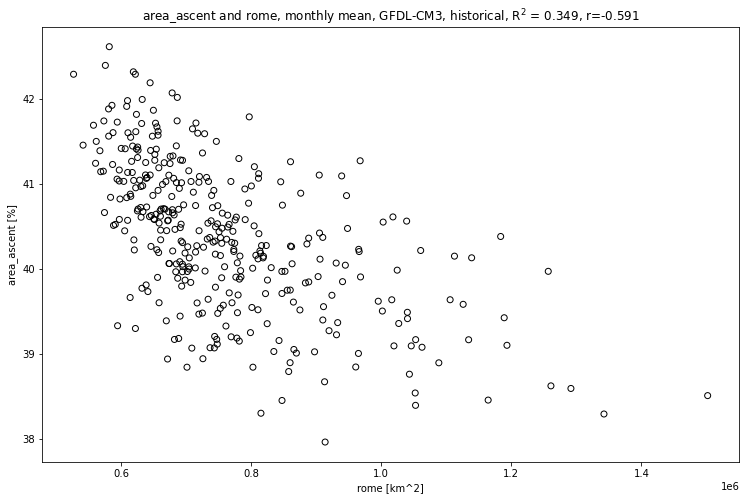

In [10]:
x = org.resample(time='M').mean(dim='time', keep_attrs=True)
y = areaFrac.resample(time='M').mean(dim='time', keep_attrs=True)
scatter_type = 'monthly mean'

plot_scatter(x,y,scatter_type)

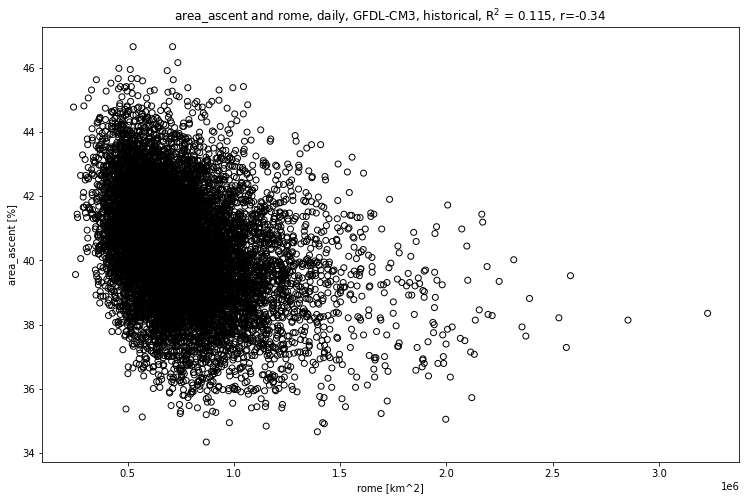

In [11]:
x = org
y = areaFrac
scatter_type = 'daily'

plot_scatter(x,y,scatter_type)

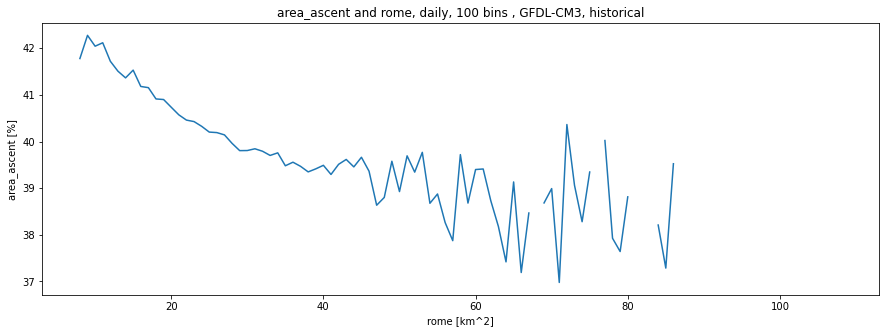

In [12]:
x = org
y = areaFrac
bin_type = 'daily, 100 bins '

plot_bins(x,y, bin_type)